<a href="https://colab.research.google.com/github/lmc2098/Redes-Neuronales/blob/main/Pr%C3%A1ctica_1_Ej_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SOLUCION DE LAS EDOs - MODELO DE HODGKIN-HUXLEY**
---


In [ ]:
from numpy import *
from matplotlib.pyplot import *
from scipy.integrate import solve_ivp
seterr(divide = 'ignore', over = 'ignore', under = 'ignore', invalid = 'ignore')

# Constantes de membrana

C = 1 # uF/cm2

g_Na = 120 # mS/cm2
g_K = 36 # mS/cm2
g_L = 0.3 # mS/cm2

V_Na = 50 # mV
V_K = -77 # mV
V_L = -54.4 # mV

# Funciones para las tasas de transición alfa y beta

def alfa_n(V):
    return 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * exp(-(V + 65) / 80)

def alfa_m(V):
    return 0.1 * (V + 40) / (1 - exp(-(V + 40) / 10))

def beta_m(V):
    return 4 * exp(- (V + 65) / 18)

def alfa_h(V):
    return 0.07 * exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + exp(-(V + 35) / 10))

# Funciones para valores estacionarios y ctes. de tiempo de m,h,n

def m_est(V):
    return alfa_m(V) / (alfa_m(V) + beta_m(V))

def h_est(V):
    return alfa_h(V) / (alfa_h(V) + beta_h(V))

def n_est(V):
    return alfa_n(V) / (alfa_n(V) + beta_n(V))

def tau_m(V):
    return 1 / (alfa_m(V) + beta_m(V))

def tau_h(V):
    return 1 / (alfa_h(V) + beta_h(V))

def tau_n(V):
    return 1 / (alfa_n(V) + beta_n(V))

# Sistema de EDOs - Modelo de Hodgkin-Huxley
def HH_EDOs(t, y, I_ext = 10, dim = 4, rel_h_n = 1):

    match dim:
      case 2:
        [V, n] = y[:2]
        m = m_est(V)
        h = rel_h_n - n
      case 3:
        [V, n, h] = y[:3]
        m = m_est(V)
      case _:
        [V, n, m, h] = y

    # Corrientes Ionicas
    I_Na = g_Na * m**3 * h * (V - V_Na)
    I_K = g_K * n**4 * (V - V_K)
    I_L = g_L * (V - V_L)
    I_ion = I_Na + I_K + I_L

    # Corriente Externa (Se puede hacer función del tiempo, definir según sea necesario)
    #I_ext = 10 # uA/cm2

    # Ecuaciones diferenciales
    match dim:
      case 2:
        dV_dt = (I_ext - I_ion) / C
        dn_dt = (n_est(V) - n) / tau_n(V)
        HH_EDOs = [dV_dt, dn_dt]

      case 3:
        dV_dt = (I_ext - I_ion) / C
        dn_dt = (n_est(V) - n) / tau_n(V)
        dh_dt = (h_est(V) - h) / tau_h(V)
        HH_EDOs = [dV_dt, dn_dt, dh_dt]

      case _:
        dV_dt = (I_ext - I_ion) / C
        dn_dt = (n_est(V) - n) / tau_n(V)
        dm_dt = (m_est(V) - m) / tau_m(V)
        dh_dt = (h_est(V) - h) / tau_h(V)
        HH_EDOs = [dV_dt, dn_dt, dm_dt, dh_dt]

    return HH_EDOs


#**GENERACIÓN DE GRÁFICOS V, n, m, h vs. t**

---



In [ ]:
def graficar():
  # Figura y subplots
  fig, axes = subplots(2, 1, figsize=(6, 6), sharex=True)
  fig.suptitle('Simulación del Modelo de Hodgkin-Huxley', fontsize=16, y=0.96)

  # Gráfico de V vs. t
  axes[0].plot(t[:int(len(t)/2)-500+1], V[:int(len(V)/2)-500+1], label='Potencial de Membrana (mV)', color='blue')
  axes[0].set_ylabel('Potencial (mV)', fontsize=11)
  axes[0].margins(x=0)
  axes[0].grid(True)

  # # Plot de n vs. t
  axes[1].plot(t[:int(len(t)/2)-500+1], n[:int(len(n)/2)-500+1], label='n', color='red')
  axes[1].plot(t[:int(len(t)/2)-500+1], m[:int(len(m)/2)-500+1], label='m', color='purple')
  axes[1].plot(t[:int(len(t)/2)-500+1], h[:int(len(h)/2)-500+1], label='h', color='green')
  axes[1].set_ylabel('Variables de disparo', fontsize=11)
  axes[1].set_xlabel('Tiempo (ms)', fontsize=11)
  axes[1].set_xticks([10, 20, 30, 40, 50])
  axes[1].margins(x=0)
  axes[1].grid(True)
  axes[1].legend()

  # Adjust layout to prevent overlapping
  tight_layout(rect=[0, 0.01, 1, 0.99]) # Adjust rectangle to make space for suptitle
  fig.savefig("dinamica_HH.pdf")
  # Display the plots
  show()


#**Cálculo de la Frecuencia**
---

In [ ]:
# Detector de picos
def picos(V, t, umbral):
    t_picos = []

    # Chequeo que los vectores tengan la misma longitud
    if len(V) != len(t):
        print("Error: Los vectores de voltaje y tiempo deben tener la misma longitud.")
        return t_picos

    # Busco máximos (excluyo los extremos del vector)
    delta_t_minimo_entre_picos = 3 # ms
    for i in range(1, len(V) - 1):
        if V[i] > umbral and V[i] > V[i-1] and V[i] > V[i+1]:
          if t_picos == []:
            t_picos.append(t[i])
          elif t[i] - t_picos[-1] > delta_t_minimo_entre_picos:
            t_picos.append(t[i])

    return t_picos

# Determino la frecuencia
def frecuencia(V,t,umbral):
    vector_frecuencia = []

    # Detección de picos
    t_picos = picos(V, t, umbral)

    # Calculo la frecuencia entre pares de picos
    if len(t_picos) < 2:
       return 0
    else:
       for i in range(0, len(t_picos) - 1):
           vector_frecuencia.append(1 / ((t_picos[i+1] - t_picos[i]) * 10**-3))

       # Calculo la frecuencia promedio
       frec = mean(vector_frecuencia)

       return frec

#**Frecuencia vs. Corriente Externa (f vs. I_ext)**

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

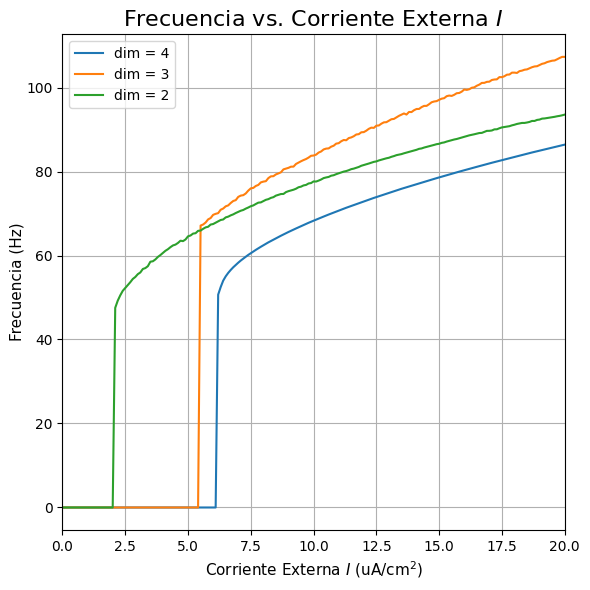

In [ ]:
from tqdm.notebook import tqdm

# Condiciones iniciales para V, n, m, h
# Valores típicos para una membrana en reposo
V_0 = -70 # mV
n_0 = n_est(V_0)
m_0 = m_est(V_0)
h_0 = h_est(V_0)

y0 = [V_0, n_0, m_0, h_0]

# Otros parámetros
umbral = -50 # mV
dim = 4 # Dimensión del sistema de EDOs para el modelo de HH
rel_h_n = h_0 + n_0 # Relación entre 'h' y 'n' para sistema Dim = 2

# Ventana de tiempo para la simulación
t_0 = 0 # ms
t_f = 100 # ms (Por ej., 50 ms)
t_ventana = (t_0, t_f)

# Opcional: Definir un vector de puntos específicos en los cuales evaluar la solución
# Por ejemplo, cada 0.01 ms
t_muestreo = 0.01 # ms
t_eval = arange(t_0, t_f, t_muestreo)

f_I_fig, ax_f_I = subplots(figsize=(6, 6))
etiquetas = []  # Lista para las etiquetas de la leyenda

for dim_count in tqdm([4, 3, 2]):
  vector_frecuencia = []
  vector_corriente = []
  for I_ext in tqdm(arange(0, 20.1, 0.1)):
      # Solucion del sistema de EDOs
      solucion = solve_ivp(HH_EDOs, t_ventana, y0[:dim_count], t_eval = t_eval, args = (I_ext, dim_count, rel_h_n,))

      # Resultados
      muestra0 = int(10/t_muestreo) # Primera muestra que tomo, para eliminar comportamientos transitorios
      t = solucion.t[muestra0:]
      V = solucion.y[0][muestra0:]
      # n = solucion.y[1][muestra0:]
      # m = solucion.y[2][muestra0:]
      # h = solucion.y[3][muestra0:]

      # if I_ext == 10:
      #   graficar()

      vector_frecuencia.append(frecuencia(V,t,umbral))
      vector_corriente.append(I_ext)
    # Al plotear, agrega el argumento label
  ax_f_I.plot(vector_corriente, vector_frecuencia, label=f'dim = {dim_count}')
  etiquetas.append(f'dim = {dim_count}')

ax_f_I.set_xlabel("Corriente Externa $I$ (uA/cm$^2$)", fontsize=11)
ax_f_I.set_ylabel("Frecuencia (Hz)", fontsize=11, labelpad=1)
ax_f_I.set_title("Frecuencia vs. Corriente Externa $I$", fontsize=16)
ax_f_I.grid(True)
ax_f_I.margins(x=0)
ax_f_I.legend(etiquetas)
f_I_fig.tight_layout()
f_I_fig.savefig("HH_f_I.pdf")
show()


In [ ]:
from google.colab import files
files.download("HH_f_I.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>